## Setup

Populating the interactive namespace from numpy and matplotlib


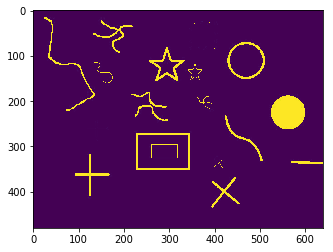

In [18]:
# Setup
%pylab inline
import matplotlib
import numpy as np
from PIL import Image
import time

# Open Image
filename = 'sobel.jpg'
im = Image.open(filename)

# Image Prep
im1 = np.array(im) # Change to Numpy Array
im = im1[:,:,0] # From RGB to Grayscale
im = np.invert(im)/255 # Invert Colors
matplotlib.pyplot.imshow(im) # Make sure numpy inverted colors

## Sobel For Magnitude and Angle

Started
took 5.4558610916137695 seconds


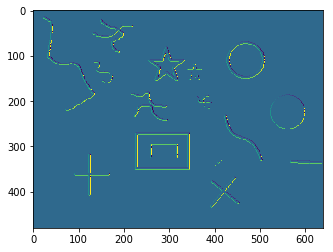

In [19]:
# Sobel Corners 2
startTime = time.time()
print('Started')

kernelx = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]])
kernely = np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])
m, n = kernelx.shape # Get Kernel Shape
w, h = im.shape
imconv = np.zeros((w,h))
ang = -1 * np.ones((w,h))
assert kernelx.shape == kernely.shape
threshold = 3
for a in range(w-m+1):
    for b in range(h-n+1):
        gx = np.sum( im[a:a+m, b:b+n]*kernelx)
        gy = np.sum( im[a:a+m, b:b+n]*kernely)
        mag = np.sqrt( gx ** 2 + gy ** 2 )
        if mag > threshold:
            imconv[a][b] = mag
            ang[a][b] = np.arctan2(gy, gx)
            
matplotlib.pyplot.imshow(ang) # Show Results of Sobel
print('took {} seconds'.format(time.time()-startTime))

## Sum of Cross Products Method I Made Up From Sobel Results

Sum of Cross Products Attempt

Maybe summing cross products of detected corners will help find strong corners

Basically for each potential corner, it will take the cross product based on the Sobel angle  for all immediate neighbors

Started
took 1.3959863185882568 seconds


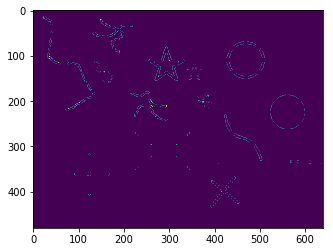

In [20]:
startTime = time.time()
print('Started')

threshold = 5

corners = np.zeros((w,h))
corner_list = []
for a in range(w-m+1):
    for b in range(h-n+1):
        ang1 = ang[a][b]
        if ang1 != -1:
            mag1 = imconv[a][b]
            ang2 = ang[a-1][b]
            if ang2 != -1: # Take Cross Product Against Left Pixel
                mag2 = imconv[a-1][b]
                vec1 = np.array([mag1*np.cos(ang1),mag1*np.sin(ang1), 0])
                vec2 = np.array([mag2*np.cos(ang2),mag2*np.sin(ang2), 0])
                left = np.abs(np.cross(vec1, vec2))
                corners[a][b] += left[2]
            ang2 = ang[a+1][b]
            if ang2 != -1: # Take Cross Product Against Right Pixel
                mag2 = imconv[a+1][b]
                vec1 = np.array([mag1*np.cos(ang1),mag1*np.sin(ang1), 0])
                vec2 = np.array([mag2*np.cos(ang2),mag2*np.sin(ang2), 0])
                right = np.abs(np.cross(vec1, vec2))
                corners[a][b] += right[2]
            ang2 = ang[a][b-1]
            if ang2 != -1: # Take Cross Product Against Above Pixel
                mag2 = imconv[a][b-1]
                vec1 = np.array([mag1*np.cos(ang1),mag1*np.sin(ang1), 0])
                vec2 = np.array([mag2*np.cos(ang2),mag2*np.sin(ang2), 0])
                up = np.abs(np.cross(vec1, vec2))
                corners[a][b] += up[2]
            ang2 = ang[a][b+1]
            if ang2 != -1: # Take Cross Product Against Below Pixel
                mag2 = imconv[a][b+1]
                vec1 = np.array([mag1*np.cos(ang1),mag1*np.sin(ang1), 0])
                vec2 = np.array([mag2*np.cos(ang2),mag2*np.sin(ang2), 0])
                down = np.abs(np.cross(vec1, vec2))
                corners[a][b] += down[2]
            if corners[a][b] > threshold:
                corner_list.append([corners[a][b], a, b])
matplotlib.pyplot.imshow(corners) # Show Magnitudes of Cross Products
print('took {} seconds'.format(time.time()-startTime))

## Find N "Best" Corners

In [21]:
startTime = time.time()
print('Started')

find_num_corners = 20
dist_thresh = 25

n = len(corner_list)
result = np.zeros((w,h))
for i in range(n):
    for j in range(0, n-i-1):
        if corner_list[j][0] < corner_list[j+1][0]:
            corner_list[j], corner_list[j+1] = corner_list[j+1], corner_list[j]

found = 0
i = 0
final_corns = []
while found < find_num_corners and i < n: # Remove Close By Corners
    current = corner_list[i]
    skip = 0
    for corner in final_corns:
        if sqrt( (current[1]-corner[1])**2 + (current[2]-corner[2])**2) < dist_thresh:
            i += 1
            skip = 1
            break
    if skip == 0:
        found += 1
        final_corns.append(current)
print('took {} seconds'.format(time.time()-startTime))

Started
took 2.231574296951294 seconds


## Prepare Image Overlaying Corners Over Original

Started


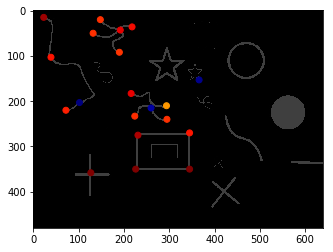

took 0.12609004974365234 seconds


In [22]:
startTime = time.time()
print('Started')

# Prep Final Image
final = np.array(im1)
final = np.invert(final)
final = final / 255
final = final / 4 # Get white pixels to 25% brightness

# Scaling
corn_max = final_corns[0][0]
corn_min = final_corns[-1][0]
disp_max = 255
disp_min = 0
slope = (disp_max-disp_min) / (corn_max-corn_min)
intercept = disp_max - slope * corn_max

# Create Dots
x, y, v = [], [], []
for corn in final_corns:
    value = slope * corn[0] + intercept
    x.append(corn[2])
    y.append(corn[1])
    v.append(value)
    
# Draw
matplotlib.pyplot.scatter(x, y, c=v, cmap='jet', linewidth=1)
matplotlib.pyplot.imshow(final)
matplotlib.pyplot.show()
print('took {} seconds'.format(time.time()-startTime))

Certainly not the best algorithm out there.

But I wanted to make something from scratch without reading how it is properly done by others.

The results are a bit better than I expected.